### 浅层神经网络_02

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import sklearn # 其它库之前我们都介绍过了。这个新库是用于数据挖掘，数据分析和机器学习的库，例如它里面就内置了很多人工智能函数
import sklearn.datasets
import sklearn.linear_model

# 下面两个库是我们自定义的，第一个提供一些工具函数，第二个提供一些单元测试工具函数。
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets 
from testCases import * 

%matplotlib inline

np.random.seed(1) # 设置一个随机数种子，来保证后面我的代码产生的随机数与你们电脑上产生的一样,这样我的结果才能和你们运行的结果一样

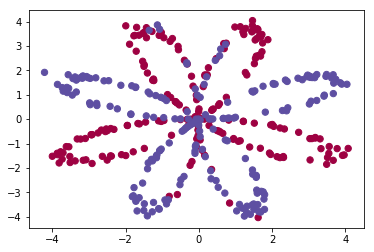

In [4]:
# 加载训练数据。这一次我们没有用真实的数据集，而是在planar_utils文件中用代码生成了一些虚拟的数据集。
# 这个数据集由400个样本组成。这400个样本是400个颜色点。输入特征X是点的横纵坐标，标签Y是点的颜色标签（0表示红色，1表示蓝色）
# 下面的图片展示了这400个颜色点。
# 我们的目标就是通过训练一个神经网络来通过坐标值判断在下图坐标系中某一点可能的颜色，
# 例如坐标（-4，2）的点可能是什么颜色，（-4，3）最可能是什么颜色。将红色和蓝色的点区分出来。
# 这好像没有上次我们编写的程序有实际意义——上次我们从图片中根据像素颜色值判断是否有猫。
# 但是我们的目的在于教学，所以不要太究竟实际用途，如果你能一路跟我走下去，是真爱粉，我后面会带你做实际项目的。
# 有些同学可能会到planar_utils文件中去看load_planar_dataset的实现。
# 如果你很了解python编程，你能看得懂里面的具体算法实现的话，你可以进去看。
# 对于一般同学，我觉得可以先不进去看，因为里面比较复杂，而且当前我们的重点是学习人工智能知识，而不是那些python编程。
# 在遇到每一个这样的函数时我会用易懂的描述让你直观的明白这个函数里面做了些什么。
# 例如下面这个函数就是构造了400个点（横着坐标）和它们对应的标签，把它们赋值到了X和Y变量中。
# 并且在构造这400点的坐标时用了一些算法以使它们形成了一个花的形状。
X, Y = load_planar_dataset()

# 下面用scatter来将数据集中的400个点画出来。
# X[0, :]表示400点的横坐标，X[1, :]表示纵坐标，c=Y.ravel()是指定400个点的颜色，s=40指定点的大小，
# cmap指定调色板，如果用不同的调色板，那么Y的值对应的颜色也会不同。用plt.cm.Spectral这个调色板时，Y等于0指代红色，1指代蓝色。
# 你可能会有疑问，为什么不直接用c=Y,而用c=Y.ravel()，它们只是维度表示方式不同，
# Y的维度是(1,400),Y.ravel()的维度是(400,)，scatter这个库函数需要后面的形式。
plt.scatter(X[0, :], X[1, :],c=Y.ravel(), s=40, cmap=plt.cm.Spectral)

In [5]:
shape_X = X.shape # 得出X的维度,维度是(2,400)，表示（横纵坐标，样本数）
shape_Y = Y.shape # 得出Y的维度,维度是(1,400)，表示（颜色标签，样本数）
m = Y.shape[1]  # 得出样本数量

print ('X的维度是: ' + str(shape_X))
print ('Y的维度: ' + str(shape_Y))
print ('训练样本的个数是：' + str(m))

X的维度是: (2, 400)
Y的维度: (1, 400)
训练样本的个数是：400


在构建浅层神经网络前，我们先快速地构建一个上一小节学的单神经元网络，先用它来执行上面的分类识别任务，然后再用浅层神经网络来进行同样的任务，这样就可以明显的对比出上一节我们学的单神经元网络是多么的弱。

上一节我们为了实现单神经元网络写了不少代码，其实如果利用sklearn这个库的话，几行代码就够了。人工智能编程和我们平时的编程一样，有很多现成的工具库，很多常用的功能函数已经被封装好了，可以大大的提升我们编程的效率。有些同学就会有疑问，那我们直接学习那些工具库就可以了呀。如果你不懂的人工智能的基本原理，只知道调用库函数的话，你将来解决问题的能力是很有限的。所以首先我要让大家对最重要的一些基本原理有直观的认识，这样大家以后才能灵活地解决各种问题，才算得上真正是懂人工智能的。

说到这里，让我想起了这么一个现象，不少程序员很喜欢背函数，而且有不少公司面试题都要求面试者能记住某些函数的参数，这是很扯淡的学习方法，很浪费时间。编程又不是考试，如果说是，那也是开卷考试，我们是可以随时查资料的。你花那么多时间精力去背函数定义有个屁用啊~~ 我们只需要明白这样函数用些什么功能作用就可以了，在编程中我们能大概知道该用哪个函数，然后去查它的具体定义进行代码编写。跟着我进行实战编程也是一样，大家不要太在意具体实现细节，要把精力放在对人工智能的直观理解上。因为初期的大部分功能代码后面都会被几个简单的库函数所取代。

In [6]:
 # 生成LogisticRegressionCV类的一个对象，LogisticRegressionCV类内部实现了一个单神经元网络
clf = sklearn.linear_model.LogisticRegressionCV();

# 将数据集传入对象中进行训练。像学习率和训练次数等超参数都有默认值，所以我们只需要简单地传入数据集就可以了。
# 这个方法会根据数据集进行训练，并将训练好的w和b参数保存在对象clf中，后面就可以用这些参数进行预测。
clf.fit(X.T, Y.T.ravel());

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


预测准确度是: 47 % 


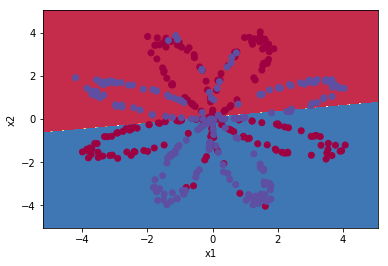

In [7]:
# 用clf对象来对数据集进行预测。我们为了简便起见，只用了训练数据集，其实应该用测试数据集的。
# 返回的结果LR_predictions中包含的是400个0或1，表示对400个点颜色的预测结果。
LR_predictions = clf.predict(X.T)

# 打印出预测准确度。下面是用了自定义的一个算法来求准确度，其实也可以简单地用clf的方法来求——clf.score(X.T,Y.T.ravel())
print ('预测准确度是: %d ' % float((np.dot(Y, LR_predictions) + np.dot(1 - Y,1 - LR_predictions)) / float(Y.size) * 100) + '% ')

# 画出预测结果图。
# 可以看到，这个单神经元网络只是简单地认为在坐标上面部分的点大致就是红色的，位于坐标下半部分的就是蓝色。
# 还是那句话，如果python功底不深的话，没有必要进去看plot_decision_boundary的实现代码。
# 我简单直观地描述下这个函数。首先，在这个函数里面，会将整个坐标的点（不仅仅是待预测花形点集X）传入到clf.predict中，
# 来得出坐标中每一个点的颜色预测值，然后根据它们画出底图（就是坐标上半部是红色下半部是蓝色的图）。
# 最后，再将待预测点集X画到底图上。通过底图和待预测点集的重叠，就可以很直观地看出神经网络预测的精准度。
# 例如，本例中预测得就很不准确，单神经元网络只是简单地认为坐标上部的点是红色，但实际上上面还有很多蓝色点，而且下面也有很多红色点。
plot_decision_boundary(lambda x: clf.predict(x), X, Y.ravel())

上面我们构建的单神经元网络预测得很不准确，下面我们将构建一个多神经元的浅层神经网络来进行同样的任务。没有对比就没有伤害~ 你会发现单神经元网络实在太弱。

我们还是老套路，先将浅层神经网络需要的各个部件各个工具函数编写好，然后再将这些函数组合起来形成一个完整的神经网络模型，然后用这个模型来训练参数，最后用训练好的参数来进行预测。

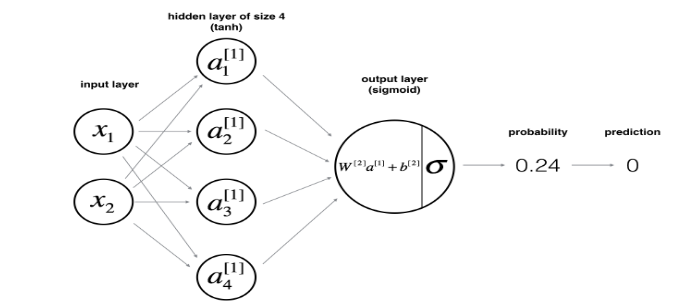

In [8]:
# 初始化参数w和b。
# 这个在单神经元实战时也有，但是那时是全都初始化为0，在多神经网络中是万万不可全初始化为0的。

def initialize_parameters(n_x, n_h, n_y):
    """
    参数:
    n_x -- 输入层的神经元个数
    n_h -- 隐藏层的神经元个数
    n_y -- 输出层的神经元个数
    """
    
    np.random.seed(2)
    
    # 随机初始化第一层（隐藏层）相关的参数w.
    # 每一个隐藏层神经元都与输入层的每一个神经元相连。每一个相连都会有一个对应的参数w。
    # 所以W1的维度是（n_h, n_x）,表示（隐藏层的神经元个数，输入层神经元个数）
    W1 = np.random.randn(n_h, n_x) * 0.01
    
    # 将第一层的参数b赋值为0，因为w已经非0了，所以b可以为0
    # 因为每一个神经元只有一个对应的b，所以b1的维度是(n_h, 1)，表示（隐藏层神经元个数，1）
    b1 = np.zeros(shape=(n_h, 1))
    
    # 同理，初始化第二层的w和b
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))
    
    # 将初始化好的参数放入一个字典变量中
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [9]:
# 这是针对于initialize_parameters函数的单元测试
# 在上一个实战编程中，不少同学在实现自己的版本期间，出现了问题，但是又很难定位问题出在哪里~~ 所以以后在每个函数后面都会加入一个单元测试
# 如果你在实现自己的版本时，发现某个函数的单元测试的输出结果和我的不一致，那么问题应该就出现在那个函数里面。
# 当然，由于python的版本可能不同，所以默认设置不同，可能会出现小数精度不一致，但是小数位前面的是一致的或结果差不多就没有问题
# 单元测试的实现细节你不需要太关心
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
#print("W1 = " + str(parameters["W1"]))
#print("b1 = " + str(parameters["b1"]))
#print("W2 = " + str(parameters["W2"]))
#print("b2 = " + str(parameters["b2"]))

#print("--------------------------------------------")

#print("nn dim(" + str(n_x) + "," + str(n_h) + "," + str(n_y) + ")");
#print("W1 dim:" + str(parameters["W1"].shape))
#print("b1 dim:" + str(parameters["b1"].shape))
#print("W2 dim:" + str(parameters["W2"].shape))
#print("b2 dim:" + str(parameters["b2"].shape))

In [10]:
# 初始化了参数后，就是我们熟悉的前向传播了
def forward_propagation(X, parameters):
    """
    参数:
    X -- 输入特征，维度是 (横纵坐标, 样本数)
    parameters -- 参数w和b
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # 从字典中取出参数
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # 实现前向传播算法
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1) # 第一层的激活函数我们使用tanh。numpy库里面已经帮我们实现了tanh工具函数
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2) # 第二层我们使用sigmoid，因为我们要解决的这个问题属于二分问题。这个函数是我们自己在planar_utils里面实现的。

    # 将这些前向传播时得出的值保存起来，因为在后面进行反向传播计算时会用到他们。
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [11]:
# 单元测试
X_assess, parameters = forward_propagation_test_case()

A2, cache = forward_propagation(X_assess, parameters)

print(np.mean(cache['Z1']), np.mean(cache['A1']), np.mean(cache['Z2']), np.mean(cache['A2']))

print("--------------------------------------------")

print("W1 dim:" + str(parameters["W1"].shape))
print("b1 dim:" + str(parameters["b1"].shape))
print("W2 dim:" + str(parameters["W2"].shape))
print("b2 dim:" + str(parameters["b2"].shape))

print("--------------------------------------------")

print("Z1 dim:" + str(cache['Z1'].shape))
print("A1 dim:" + str(cache['A1'].shape))
print("Z2 dim:" + str(cache['Z2'].shape))
print("A2 dim:" + str(cache['A2'].shape))

-0.0004997557777419913 -0.000496963353231779 0.00043818745095914653 0.500109546852431
--------------------------------------------
W1 dim:(4, 2)
b1 dim:(4, 1)
W2 dim:(1, 4)
b2 dim:(1, 1)
--------------------------------------------
Z1 dim:(4, 3)
A1 dim:(4, 3)
Z2 dim:(1, 3)
A2 dim:(1, 3)


In [12]:
# 这个函数被用来计算成本
def compute_cost(A2, Y, parameters):
    """   
    参数:
    A2 -- 神经网络最后一层的输出结果
    Y -- 数据的颜色标签
    """
    
    m = Y.shape[1] 
    
    logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
    cost = - np.sum(logprobs) / m
    
    return cost

In [13]:
A2, Y_assess, parameters = compute_cost_test_case()

print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

cost = 0.6929198937761266


In [14]:
# 然后就是反向传播
def backward_propagation(parameters, cache, X, Y):
    """
    参数:
    parameters -- 参数w和b
    cache -- 前向传播时保存起来的一些数据
    X -- 输入特征
    Y -- 标签
    """
    m = X.shape[1] # 获取样本数
    
    W1 = parameters['W1']
    W2 = parameters['W2']
        
    A1 = cache['A1']
    A2 = cache['A2']
    
    # 根据我们文章中介绍的算法公式来计算梯度（偏导数）
    dZ2= A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
#    print("W1 dim:" + str(W1.shape))
#    print("W2 dim:" + str(W2.shape))
#    print("------------------------------")
    
#    print("dZ2 dim:" + str(dZ2.shape))
#    print("dZ1 dim:" + str(dZ1.shape))
#    print("------------------------------")
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads # 返回计算得到的梯度

In [15]:
# 单元测试
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)

print("dW1 dim:" + str(grads["dW1"].shape))
print("db1 dim:" + str(grads["db1"].shape))
print("dW2 dim:" + str(grads["dW2"].shape))
print("db2 dim:" + str(grads["db2"].shape))
print("------------------------------")

print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 dim:(4, 2)
db1 dim:(4, 1)
dW2 dim:(1, 4)
db2 dim:(1, 1)
------------------------------
dW1 = [[ 0.01018708 -0.00708701]
 [ 0.00873447 -0.0060768 ]
 [-0.00530847  0.00369379]
 [-0.02206365  0.01535126]]
db1 = [[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]]
dW2 = [[ 0.00363613  0.03153604  0.01162914 -0.01318316]]
db2 = [[0.06589489]]


In [16]:
# 用上面得到的梯度来进行梯度下降（更新参数w和b，使其更优化）
def update_parameters(parameters, grads, learning_rate=1.2):
    """
    参数:
    parameters -- 参数w和b 
    grads -- 梯度
    """

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    # 根据梯度和学习率来更新参数，使其更优
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [ ]:
# 单元测试
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


In [39]:
# 上面已经将各个所需的功能函数都编写好了。现在我们将它们组合在一个大函数中来构建出一个训练模型。
def nn_model(X, Y, n_h, num_iterations=10000, print_cost=False):
    """
    Arguments:
    X -- 输入特征
    Y -- 标签
    n_h -- 隐藏层的神经元个数
    num_iterations -- 训练多少次
    print_cost -- 是否打印出成本
    """
    
    np.random.seed(3)
    n_x = X.shape[0] # 根据输入特征的维度得出输入层的神经元个数
    n_y = Y.shape[0] # 根据标签的维度得出输出层的神经元个数
    

    # 初始化参数
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # 在这个循环里进行训练，一次一次地对参数进行优化
    for i in range(0, num_iterations):
        # 进行前向传播
        A2, cache = forward_propagation(X, parameters)
        
        # 计算出本次的成本
        cost = compute_cost(A2, Y, parameters)
 
        # 进行反向传播。根据前向传播得到的一些值算出梯度。
        grads = backward_propagation(parameters, cache, X, Y)
 
        # 根据梯度对参数进行一次优化（下降）
        parameters = update_parameters(parameters, grads)
                
        # 将本次训练的成本打印出来
        if print_cost and i % 1000 == 0:
            print ("在训练%i次后，成本是: %f" % (i, cost))

    return parameters

In [40]:
# 单元测试
X_assess, Y_assess = nn_model_test_case()

parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=False)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/home/coding/workspace/ai/ai_02/planar_utils.py:34: RuntimeWarning: overflow encountered in exp
  s = 1/(1+np.exp(-x))


W1 = [[-4.18503197  5.33214315]
 [-7.52988635  1.24306559]
 [-4.19302427  5.32627154]
 [ 7.52984762 -1.24308746]]
b1 = [[ 2.32926944]
 [ 3.79460252]
 [ 2.33002498]
 [-3.79466751]]
W2 = [[-6033.83668723 -6008.12983227 -6033.10091631  6008.06624417]]
b2 = [[-52.66610924]]


In [41]:
# 我们已经可以通过上面的函数来进行参数训练。
# 这个函数可以利用上面学习到的参数来对新数据进行预测
def predict(parameters, X):
    """    
    参数:
    parameters -- 训练得出的参数（学习到的参数）
    X -- 预测数据
    """
    
    # 预测其实就是简单地执行一次前向传播
    A2, cache = forward_propagation(X, parameters)
    predictions = np.round(A2) # 对结果进行四舍五入，小于0.5就是0，否则就是1
    
    return predictions

In [42]:
# 单元测试
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.6666666666666666


在训练0次后，成本是: 0.693048
在训练1000次后，成本是: 0.288083
在训练2000次后，成本是: 0.254385
在训练3000次后，成本是: 0.233864
在训练4000次后，成本是: 0.226792
在训练5000次后，成本是: 0.222644
在训练6000次后，成本是: 0.219731
在训练7000次后，成本是: 0.217504
在训练8000次后，成本是: 0.219467
在训练9000次后，成本是: 0.218561
预测准确率是: 90%


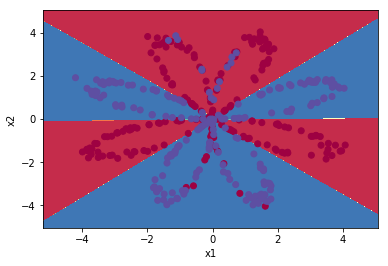

In [43]:
# 好，所有函数都实现完毕了，我们已经构建好了一个浅层神经网络了。
# 现在用这个浅层神经网络来执行与文章开头的单神经元网络同样的任务——将花形图案中的红蓝点区分开

# 首先是根据训练数据来进行参数学习（训练数据是与单神经元网络一样一样的）
parameters = nn_model(X, Y, n_h = 4, num_iterations=10000, print_cost=True)

# 然后用训练得出的参数进行预测。
predictions = predict(parameters, X)
print ('预测准确率是: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

# 将预测结果画出来。
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y.ravel())

从上面的结果可以看出，准确率达到了90%，从画出的图形也可以看出，基本上都区分对了。

单神经元网络时才47%，这个进步是相当大的。

在这个2层的浅层神经网络中，隐藏层我们只用了4个神经元，其实如果神经元更多些，预测结果会更准确一些。

当然也不少越多越准确，具体应该多少个神经元合适，在以后的文章中我会教大家的。

下面提供了一段代码，分别对比了当隐藏层神经元个数不同时，预测结果的准确度。

1个隐藏层神经元时的准确度是: 67.5 %
2个隐藏层神经元时的准确度是: 67.25 %
3个隐藏层神经元时的准确度是: 90.75 %
4个隐藏层神经元时的准确度是: 90.5 %
5个隐藏层神经元时的准确度是: 91.25 %
20个隐藏层神经元时的准确度是: 90.5 %
50个隐藏层神经元时的准确度是: 90.75 %


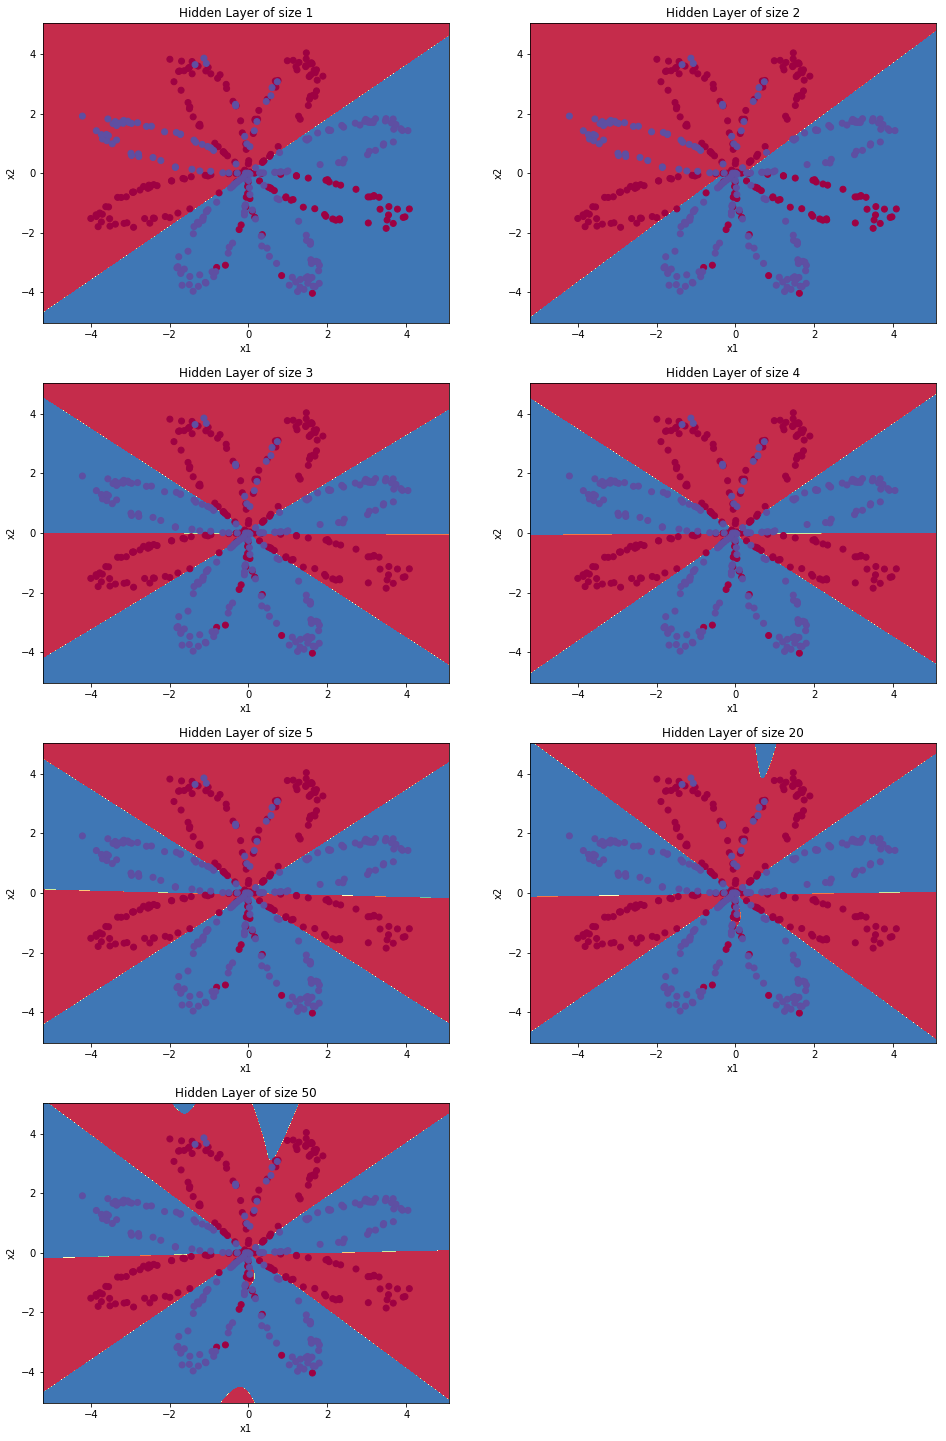

In [44]:
# 展示不同神经元个数的不同准确度。这段代码可以要运行几分钟。

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50] # 不同的神经元个数
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i + 1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations=5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y.ravel())
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100)
    print ("{}个隐藏层神经元时的准确度是: {} %".format(n_h, accuracy))